In [1]:
import os
import sys

sys.path.append('..')
os.environ["OMP_NUM_THREADS"] = '1'  # KMeans is not parallelized, so set to 1 thread

from src.mutation import Mutation
from src.sequence import Plasmid
from src.eblocks import Eblock, EblockDesign
from src.primer import DesignPrimers
from src.plot import Plot
from src.utils import Utils, SnapGene

%reload_ext autoreload
%autoreload 2

In [2]:
# TODO SIZES OF CLONES ARE NOT CORRECT!!

In [3]:
# Create a Mutation object and parse the input mutations from the files/ directory

mutations_file = 'files/mutations.txt'
mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12.txt'
mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12_2.txt'
mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12_3.txt'
mutations_file = 'files/mutations_random_DnaE1_N27_2024-04-12_4.txt'
mutations_file = 'files/mutations_begin_end_of_gene.txt'

mutation_instance = Mutation()
mutation_instance.parse_mutations(mutations_file)

# Print the mutations that were parsed

mutation_instance.print_mutations()

The selected mutations are:
	Mutation  	M1G       
	Mutation  	M1F       
	Mutation  	M1S       
	Combined  	M1G, S2G, F10P
	Mutation  	S2G       
	Mutation  	G3P       
	Mutation  	F10P      
	Insert    	R204-FTSMM
	Mutation  	D208I     
	Deletion  	I289-Y296 
	Mutation  	G383N     
	Mutation  	T397V     
	Combined  	G535C, C578S, G567L, L583R, P564Q
	Insert    	G535-DDVIIC
	Mutation  	E579L     
	Mutation  	M586V     
	Combined  	D620M, G629V, E626R
	Mutation  	Q716V     
	Combined  	M810V, S852L, P841S, V843F, L848M
	Deletion  	K910-A913 
	Mutation  	E1057R    
	Mutation  	R1135T    
	Mutation  	G1138E    
	Mutation  	L1182W    
	Mutation  	G1183P    
	Mutation  	S1184G    
	Combined  	S1184G, G1183P, L1182W


In [4]:
# Create a Plasmid object and parse the input plasmid from the files/ directory

sequence_file = 'files/A0QX55.fasta'
vector_file = 'files/vector.dna'

sequence_instance = Plasmid()
sequence_instance.parse_vector(vector_file)
sequence_instance.parse_sequence(sequence_file)

1

In [5]:
# Create a SnapGene instance to write the eBlocks features to a snapgene file

# Set output directory
output_dir = 'output'

snapgene_instance = SnapGene(sequence_instance=sequence_instance,
                             output_dir=output_dir)

In [6]:
# Create an Eblocks object based on the input mutations and the gene sequence

# Print some information about the processes
verbose = True

design_instance = EblockDesign(mutation_instance=mutation_instance,
                               sequence_instance=sequence_instance,
                               output_dir=output_dir,
                               cost_optimization=False,
                               amount_optimization=True)

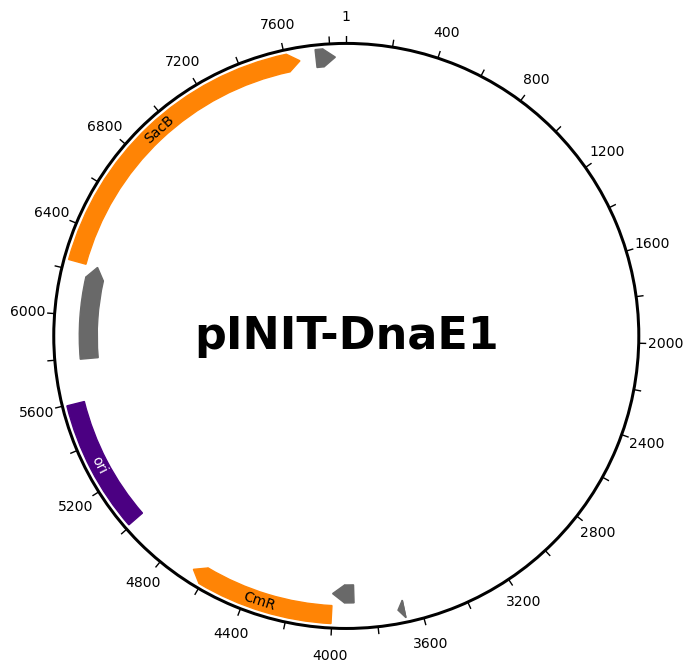

In [7]:
# Create a Plots object and check the input vector

# Create the Plot object
plot_instance = Plot(mutation_instance=mutation_instance,
                     eblocks_design_instance=design_instance,
                     sequence_instance=sequence_instance,
                     output_dir=output_dir,
                     show=True)

# Check the input vector
plot_instance.plot_vector(figsize=(7, 7));

# TODO Show eBlocks in vector as well

In [8]:
# TODO Add plasmid visaulization of eBlock features


# from Bio import SeqIO
# from Bio.Graphics import GenomeDiagram
# from Bio.SeqFeature import SeqFeature, FeatureLocation

# # Parse the plasmid sequence
# plasmid_seq_record = SeqIO.read("plasmid_sequence.fasta", "fasta")

# # Create a GenomeDiagram object
# gd_diagram = GenomeDiagram.Diagram("Plasmid Map")

# # Add the sequence track
# gd_track = gd_diagram.new_track(1, name="Plasmid")
# gd_feature_set = gd_track.new_set()

# # Add the plasmid sequence
# gd_feature_set.add_feature(SeqFeature(FeatureLocation(0, len(plasmid_seq_record))), color="black")

# # Parse the GFF3 file to extract features
# # Assuming you have a function parse_gff3() that returns feature information
# features = parse_gff3("plasmid_features.gff3")

# # Add the features to the plasmid map
# for feature in features:
#     start = feature.start
#     end = feature.end
#     name = feature.attributes["Name"]
#     gd_feature_set.add_feature(SeqFeature(FeatureLocation(start, end)), color="blue", label=True, label_position="middle", label_size=8, label_angle=0, label_strand=0, name=name)

# # Draw the plasmid map
# gd_diagram.draw(format="linear", pagesize=(15*len(plasmid_seq_record), 400), fragments=1)
# gd_diagram.write("plasmid_map.png", "png")


In [11]:
# Run the eBlocks design and print the results

design_instance.verbose = False

design_instance.run_design_eblocks()

start_index -9 end_index 926
start_index 1137 end_index 2186
start_index 2418 end_index 3590
['M1G']
['M1F']
['M1S']
['S2G']
['G3P']
['F10P']
['D208I']
['G383N']
['T397V']
['E579L']
['M586V']
['Q716V']
['E1057R']
['R1135T']
['G1138E']
['L1182W']
['G1183P']
['S1184G']
['M1G']
eblock.start_index 7862
eblock.end_index 926
eBlock-1 [7862, 926, '#ff7f0e']
7871
dnaE1 [13, 3568, '#d3d3d3']
M1G [13, 16, 'black']
['M1F']
eblock.start_index 7862
eblock.end_index 926
eBlock-1 [7862, 926, '#ff7f0e']
7871
dnaE1 [13, 3568, '#d3d3d3']
M1F [13, 16, 'black']
['M1S']
eblock.start_index 7862
eblock.end_index 926
eBlock-1 [7862, 926, '#ff7f0e']
7871
dnaE1 [13, 3568, '#d3d3d3']
M1S [13, 16, 'black']
['M1G', 'S2G', 'F10P']
eblock.start_index 7862
eblock.end_index 926
eBlock-1 [7862, 926, '#ff7f0e']
7871
dnaE1 [13, 3568, '#d3d3d3']
M1G [13, 16, 'green']
S2G [16, 19, 'green']
F10P [40, 43, 'green']
['S2G']
eblock.start_index 7862
eblock.end_index 926
eBlock-1 [7862, 926, '#ff7f0e']
7871
dnaE1 [13, 3568, '#d3d

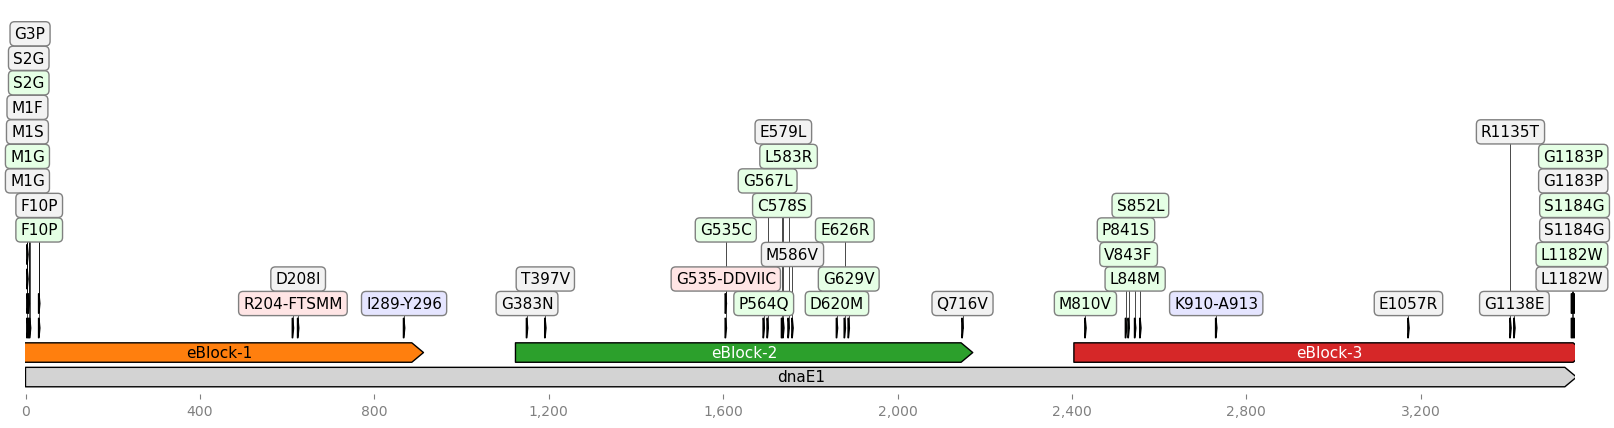

In [15]:
# Now that we have designed the eblocks, we can visualize them using the Plot class

plot_instance.plot_eblocks_mutations(figure_length=20,
                                     figure_width=5)

In [16]:
# TODO Describe the eblocks here, what you can see with each color etc

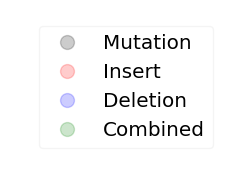

In [17]:
# Each type of mutations (insertions, deletions, substitutions) is represented by a different color, you can see the legend below

plot_instance.plot_mutation_legend()

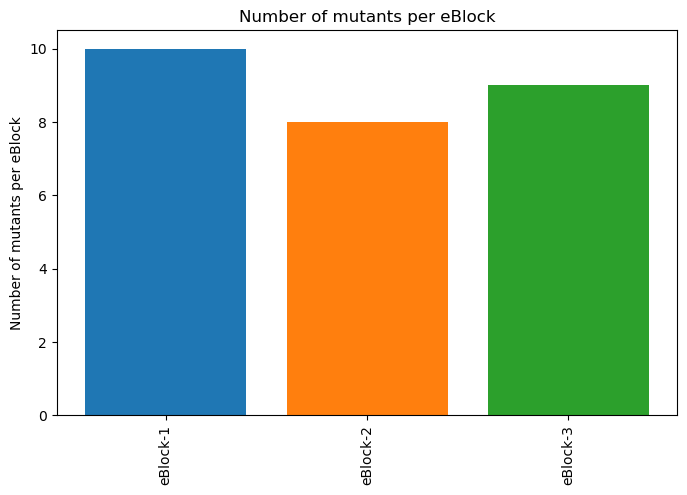

In [18]:
# To see how many mutations can be made in each eBlock, we can plot a histogram

plot_instance.plot_histogram_mutations()

In [19]:
for eblock, mutation in design_instance.eblocks.items():
    print(f"{eblock}: {mutation}")

<src.mutation.Mutation object at 0x0000016ADFE53560>: <src.eblocks.Eblock object at 0x0000016ADFA39970>
<src.mutation.Mutation object at 0x0000016ADFE534D0>: <src.eblocks.Eblock object at 0x0000016ADAD5FE30>
<src.mutation.Mutation object at 0x0000016ADFE52A80>: <src.eblocks.Eblock object at 0x0000016AE070A270>
<src.mutation.Mutation object at 0x0000016ADFE52F60>: <src.eblocks.Eblock object at 0x0000016AE1AED7C0>
<src.mutation.Mutation object at 0x0000016ADFE53590>: <src.eblocks.Eblock object at 0x0000016AE0709FD0>
<src.mutation.Mutation object at 0x0000016ADFE535F0>: <src.eblocks.Eblock object at 0x0000016AE1AEF440>
<src.mutation.Mutation object at 0x0000016ADFE532F0>: <src.eblocks.Eblock object at 0x0000016AE1AEF560>
<src.mutation.Mutation object at 0x0000016ADFE536E0>: <src.eblocks.Eblock object at 0x0000016AE1AEF6B0>
<src.mutation.Mutation object at 0x0000016ADFE53290>: <src.eblocks.Eblock object at 0x0000016AE1AEE870>
<src.mutation.Mutation object at 0x0000016ADFE53650>: <src.ebloc

In [20]:
# TODO Do some explanation here

In [21]:
# TODO Save the eblocks to a file

In [22]:
# TODO (At the end of tutorial) Remake the eBlocks but optimize for amount of eBlocks

In [23]:
# Create a primer design object and run the primer design process for IVA primers to amplify the eblocks

primers_instance = DesignPrimers(mutation_instance=mutation_instance,
                                 eblocks_design_instance=design_instance,
                                 sequence_instance=sequence_instance, 
                                 output_dir=output_dir,
                                 snapgene_instance=snapgene_instance)

primers_instance.run_design()

In [24]:
59 - 14

45

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

# TODO AT THE END OF THE TURORIAL CREATE A PDF WITH ALL THE PLOTS AND THE SEQUENCES

# TODO TRY RUNNING TESTS FROM COMMAND LINE AS WELL AND SEE IF THIS WORKS

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted